# Modélisation – Régression Logistique

L’objectif de cette étape est d’estimer la probabilité qu’une tumeur soit maligne à partir de certaines caractéristiques morphologiques.

La régression logistique est utilisée car :

- La variable cible (`diagnosis`) est binaire (0 = bénin, 1 = malin).
- Elle permet d’estimer une probabilité comprise entre 0 et 1.
- Elle offre une interprétation claire des effets des variables explicatives.

In [2]:
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import numpy as np

In [3]:
df_clean = pd.read_csv("../data/data_cleaning.csv")

## Modèle logistique univarié – Périmètre moyen

On estime dans un premier temps un modèle simple incluant uniquement `perimeter_mean` afin d’évaluer l’effet isolé de la taille de la tumeur sur la probabilité de malignité.

La régression logistique modélise les log-odds selon la relation :
log(p / (1 - p)) = β₀ + β₁ × perimeter_mean

<Axes: xlabel='perimeter_mean', ylabel='diagnosis'>

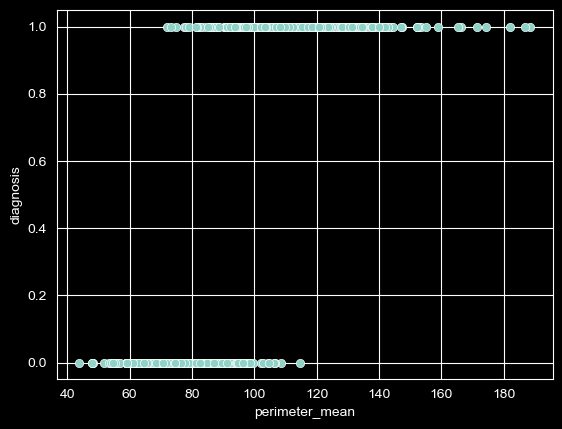

In [4]:
sns.scatterplot(data=df_clean, x="perimeter_mean", y="diagnosis")

In [5]:
perimeter_model = smf.logit(formula='diagnosis ~ perimeter_mean', data=df_clean)
perimeter_result = perimeter_model.fit()
perimeter_result.params

Optimization terminated successfully.
         Current function value: 0.267561
         Iterations 8


Intercept        -15.713328
perimeter_mean     0.163986
dtype: float64

### Interprétation

L’intercept correspond aux log-odds de malignité lorsque le périmètre est nul.

Le coefficient associé au périmètre moyen indique qu’une augmentation d’une unité de cette variable accroît les log-odds de malignité.

Autrement dit, plus la tumeur est grande, plus la probabilité estimée d’être maligne augmente, ce qui est cohérent d’un point de vue médical.

In [6]:
np.random.seed(42)

row = df_clean.sample(n=1, random_state=42)
x = row["perimeter_mean"].iloc[0]

b0 = perimeter_result.params["Intercept"]
b1 = perimeter_result.params["perimeter_mean"]

log_odds = b0 + b1 * x
p = 1 / (1 + np.exp(-log_odds))

print("perimeter_mean =", x)
print("probabilité prédite =", p)

perimeter_mean = 81.09
probabilité prédite = 0.08198267162312863


Pour une observation présentant un périmètre moyen de 81,09, le modèle estime une probabilité de malignité d’environ 8 %.

Cela correspond à un risque relativement faible lorsque l’on considère uniquement cette variable explicative.

## Modèle logistique univarié – Concavité moyenne

On estime ensuite un modèle incluant uniquement `concavity_mean`.

Cette variable décrit l’irrégularité de la forme de la tumeur. Une concavité plus élevée peut refléter une structure plus agressive et donc un risque accru de malignité.

<Axes: xlabel='concavity_mean', ylabel='diagnosis'>

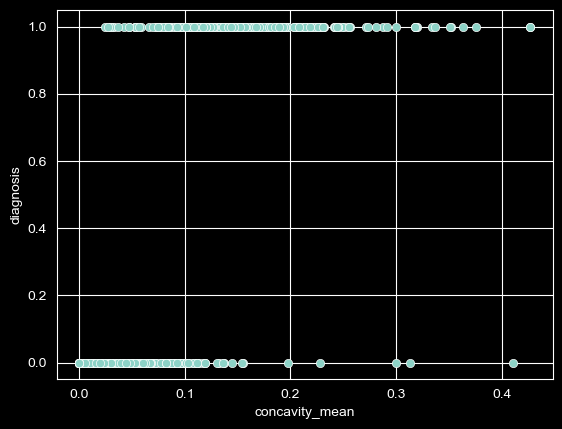

In [7]:
sns.scatterplot(data=df_clean, x="concavity_mean", y="diagnosis")

In [8]:
concavity_model = smf.logit(formula='diagnosis ~ concavity_mean', data=df_clean)
concavity_result = concavity_model.fit()
concavity_result.params

Optimization terminated successfully.
         Current function value: 0.336755
         Iterations 7


Intercept         -3.784990
concavity_mean    36.845698
dtype: float64

In [9]:
x = row["concavity_mean"].iloc[0]

b0 = concavity_result.params["Intercept"]
b1 = concavity_result.params["concavity_mean"]

log_odds = b0 + b1 * x
p = np.exp(log_odds) / (1 + np.exp(log_odds))

print("concavity_mean =", x)
print("probabilité prédite =", p)

concavity_mean = 0.08005
probabilité prédite = 0.30248502217351025


Selon ce modèle logistique univarié, une tumeur présentant une concavité moyenne de 0,08 est associée à une probabilité estimée d’environ 30 % d’être maligne.

## Passage au modèle multivarié

Les variables étudiées peuvent être corrélées entre elles et partager une partie de l’information explicative.

Il est donc nécessaire d’estimer un modèle multivarié afin d’isoler l’effet propre de chaque variable, toutes choses égales par ailleurs.

In [10]:
all_model = smf.logit(formula='diagnosis ~  concavity_mean + perimeter_mean', data=df_clean)
all_result = all_model.fit()
all_result.params

Optimization terminated successfully.
         Current function value: 0.201960
         Iterations 9


Intercept        -15.858872
concavity_mean    24.595351
perimeter_mean     0.142576
dtype: float64

L’intercept représente la valeur des log-odds de malignité lorsque le périmètre et la concavité sont égaux à zéro.

In [11]:
all_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              diagnosis   No. Observations:                  569
Model:                          Logit   Df Residuals:                      566
Method:                           MLE   Df Model:                            2
Date:                Mon, 16 Feb 2026   Pseudo R-squ.:                  0.6941
Time:                        21:51:38   Log-Likelihood:                -114.92
converged:                       True   LL-Null:                       -375.72
Covariance Type:            nonrobust   LLR p-value:                5.418e-114
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -15.8589      1.593     -9.958      0.000     -18.980     -12.737
concavity_mean    24.5954      3.347      7.350      0.000      18.036      31.154
perimeter_mean     0.1426      0.016      8.652      0.000       0.110       0.175
==================================================================================
"""

In [12]:
b0 = all_result.params["Intercept"]
b1 = all_result.params["concavity_mean"]
b2 = all_result.params["perimeter_mean"]

x1 = row["concavity_mean"].iloc[0]
x2 = row["perimeter_mean"].iloc[0]

log_odds = b0 + b1*x1 + b2*x2
p = np.exp(log_odds) / (1 + np.exp(log_odds))

print("concavity_mean =", x1)
print("perimeter_mean =", x2)
print(p)

concavity_mean = 0.08005
perimeter_mean = 81.09
0.08878628898812546


Dans le modèle multivarié, l’intercept représente les log-odds de malignité lorsque le périmètre, la compacité et la concavité sont égaux à zéro.

Pour une tumeur présentant :

- une concavité moyenne de 0,080,
- un périmètre moyen de 81,09 mm,

le modèle logistique multivarié estime une probabilité de malignité d’environ 9 %.


### Conclusion

Cette analyse met en évidence l’importance des caractéristiques morphologiques liées à la taille et à l’irrégularité de la forme, dans la prédiction de la malignité des tumeurs du sein.

La régression logistique permet de combiner ces informations afin d’estimer une probabilité de malignité.

Il convient toutefois de rappeler qu’il s’agit d’un outil statistique d’aide à la décision et non d’un diagnostic médical.